In [ ]:
"""Training a tennis vs pickleball scene classifier."""

import matplotlib.pyplot as plt

import time
from tempfile import TemporaryDirectory
import os

import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, Compose, Grayscale, ToTensor, Normalize
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import random_split
import torch.nn as nn

from custom_dataset import PballTennisDataset

In [21]:
# We're using resnet 50 as a feature extracter.
weights = ResNet50_Weights.IMAGENET1K_V1
transforms = weights.transforms()
model = resnet50(weights=weights)

# Load the dataset, split into train, validation, test.
dataset = PballTennisDataset(
    dir='C:/Users/echapman/Downloads/AutoCrawler/download/',
    transform=transforms,
)

valid_size = test_size = int(0.15 * len(dataset))
train_size = len(dataset) - valid_size - test_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Freeze the base. We're only training a classification head.
for param in model.parameters():
    param.requires_grad = False

# Dense classification head
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Send model to GPU
device = torch.device("cuda:0")
model = model.to(device)

# Tune hyperparameters here
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 10

In [22]:
def train_model(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=25):
    dataloaders = {
        'train': train_dataloader,
        'val': valid_dataloader,
    }
    
    since = time.time()

    # Track our training and validation losses per epoch
    train_losses = []
    valid_losses = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10) 

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.float()
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                size = len(dataloaders[phase].dataset)
                epoch_loss = running_loss / size
                epoch_acc = running_corrects.double() / size

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'train':
                    train_losses.append(epoch_loss)
                else:
                    valid_losses.append(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_losses, valid_losses

model, train_losses, valid_losses = train_model(
    model, criterion, optimizer, exp_lr_scheduler,
    train_dataloader, valid_dataloader,
    num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.5819 Acc: 0.6940
val Loss: 0.4976 Acc: 0.7485

Epoch 1/9
----------
train Loss: 0.4770 Acc: 0.7781
val Loss: 0.4469 Acc: 0.8085

Epoch 2/9
----------
train Loss: 0.4360 Acc: 0.8116
val Loss: 0.4194 Acc: 0.8240

Epoch 3/9
----------
train Loss: 0.4179 Acc: 0.8240
val Loss: 0.4220 Acc: 0.8182

Epoch 4/9
----------
train Loss: 0.4090 Acc: 0.8240
val Loss: 0.4150 Acc: 0.8143

Epoch 5/9
----------
train Loss: 0.4014 Acc: 0.8211
val Loss: 0.4223 Acc: 0.7950

Epoch 6/9
----------
train Loss: 0.3919 Acc: 0.8277
val Loss: 0.3972 Acc: 0.8221

Epoch 7/9
----------
train Loss: 0.3822 Acc: 0.8389
val Loss: 0.4033 Acc: 0.8182

Epoch 8/9
----------
train Loss: 0.3817 Acc: 0.8381
val Loss: 0.3984 Acc: 0.8298

Epoch 9/9
----------
train Loss: 0.3783 Acc: 0.8414
val Loss: 0.4014 Acc: 0.8240

Training complete in 2m 45s
Best val Acc: 0.829787


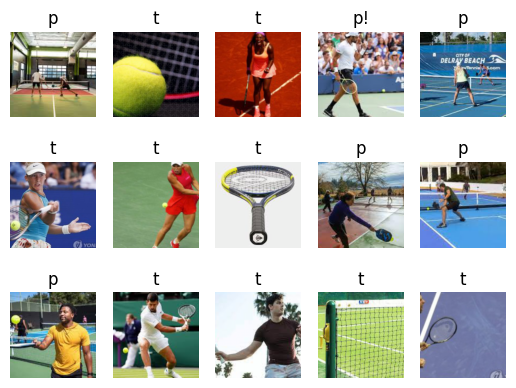

In [49]:
def visualize_model(model, dataloader, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.float()
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            wrongs = ~preds.eq(labels)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(int(np.ceil(num_images//5)), 5, images_so_far)
                ax.axis('off')
                title = class_names[preds[j]]
                if wrongs[j]:
                    title += "!"
                ax.set_title(title)
                imshow(inputs.cpu().data[j], ax)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def imshow(inp, ax):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)).astype(float)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    # plt.pause(0.001)  # pause a bit so that plots are updated


visualize_model(
    model, test_dataloader,
    class_names=["p", "t"], num_images=15)
plt.ioff()
plt.show()

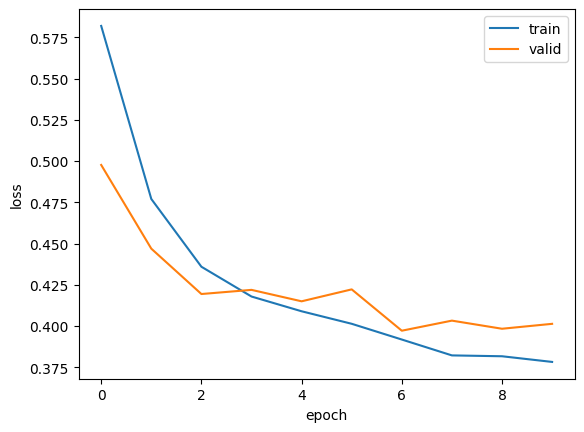

In [31]:
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [42]:
def test_model_accuracy(model, dataloader):
    was_training = model.training
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.float()
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += float(torch.sum(preds.eq(labels)))
            total += float(torch.numel(labels))

        model.train(mode=was_training)

    return correct / total

print("model accuracy:", test_model_accuracy(model, test_dataloader))

model accuracy: 0.8143133462282398


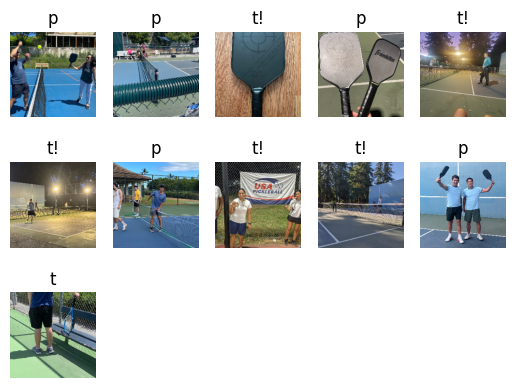

In [44]:
personal_dataset = PballTennisDataset(
    dir='C:/Users/echapman/Downloads/my_photos/',
    transform=transforms,
)
personal_dataloader = DataLoader(personal_dataset, batch_size=64, shuffle=False)

visualize_model(
    model, personal_dataloader,
    class_names=["p", "t"], num_images=15)
plt.ioff()
plt.show()